In [73]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import cv2
import open3d as o3d

In [74]:
DIR_PATH = "datasets\CV-A2-calibration"

class LidarImage:

    def __init__(self, filename):
        self.filename = filename
        self.image = cv2.imread(f"{DIR_PATH}\camera_images\{filename}.jpeg")
        self.lidar_scan = o3d.io.read_point_cloud(f"{DIR_PATH}\lidar_scans\{filename}.pcd")
        self.camera_normals = np.loadtxt(f"{DIR_PATH}\camera_parameters\{filename}.jpeg\camera_normals.txt")
        self.rotation_matrix = np.loadtxt(f"{DIR_PATH}\camera_parameters\{filename}.jpeg\\rotation_matrix.txt")
        self.rotation_vector = np.loadtxt(f"{DIR_PATH}\camera_parameters\{filename}.jpeg\\rotation_vectors.txt")
        self.translation_vector = np.loadtxt(f"{DIR_PATH}\camera_parameters\{filename}.jpeg\\translation_vectors.txt")

    def show_image(self):
        cv2.imshow('image', self.image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    def show_lidar(self):
        o3d.visualization.draw_geometries([self.lidar_scan])

    def show_camera_param(self):
        print(self.camera_param)

    def __str__(self) -> str:
        return f"Image: {self.filename}"


In [75]:
image_names = []
for image in os.listdir(DIR_PATH + '\camera_images'):
    if image.endswith('.jpeg'):
        image_names.append(image.split('.')[0])

# Randomly sample 25 images
sampled_images = list(np.random.choice(image_names, 25))
print(sampled_images)

lidar_images = [LidarImage(image) for image in sampled_images]

camera_instrinsic = np.loadtxt(f"{DIR_PATH}\camera_parameters\camera_intrinsic.txt")
camera_distortion = np.loadtxt(f"{DIR_PATH}\camera_parameters\distortion.txt")

['frame_1163', 'frame_2991', 'frame_690', 'frame_1725', 'frame_2991', 'frame_3329', 'frame_548', 'frame_1698', 'frame_548', 'frame_2107', 'frame_1580', 'frame_795', 'frame_256', 'frame_1798', 'frame_457', 'frame_812', 'frame_1698', 'frame_1163', 'frame_2725', 'frame_1093', 'frame_1850', 'frame_1139', 'frame_1093', 'frame_1638', 'frame_339']


In [76]:
# For all images, compute the plane normal and offset
lidar_normals = []
lidar_offsets = []
camera_offsets = []

for image in lidar_images:
    points = np.asarray(image.lidar_scan.points)
    lidar_centroid = np.mean(points, axis=0)
    centered_points = points - lidar_centroid

    # Normal is the last column of the Vt matrix from SVD
    _, _, Vt = np.linalg.svd(centered_points)
    lidar_normal = Vt[-1]


    # Normalize the lidar normal and camera normal
    image.camera_normals = image.camera_normals / np.linalg.norm(image.camera_normals)
    lidar_normal = lidar_normal / np.linalg.norm(lidar_normal)
    lidar_offset = np.dot(lidar_normal, lidar_centroid)
    if lidar_offset < 0:
        lidar_normal = -lidar_normal
        lidar_offset = -lidar_offset
    lidar_normals.append(lidar_normal)
    lidar_offsets.append(lidar_offset)
    camera_offset = np.dot(image.camera_normals, image.translation_vector.T)
    if camera_offset < 0:
        image.camera_normals = -image.camera_normals
        camera_offset = -camera_offset
    camera_offsets.append(camera_offset)

    print(f"Image: {image.filename}\n Lidar Normal: {lidar_normal}\n Lidar Offset: {lidar_offset}\n Camera Offset: {np.dot(image.camera_normals, image.translation_vector.T)}\n")

Image: frame_1163
 Lidar Normal: [ 0.91935323 -0.3607026   0.15710911]
 Lidar Offset: 5.702524575286329
 Camera Offset: 5.205498545083516

Image: frame_2991
 Lidar Normal: [ 0.60371533 -0.79239849  0.08736381]
 Lidar Offset: 3.70387562109441
 Camera Offset: 3.2669594619812075

Image: frame_690
 Lidar Normal: [ 0.99427448 -0.1042191   0.02359328]
 Lidar Offset: 8.846168921169088
 Camera Offset: 8.224076199102935

Image: frame_1725
 Lidar Normal: [ 0.40409023 -0.88184713  0.24301591]
 Lidar Offset: 5.436720512190619
 Camera Offset: 5.292352438609255

Image: frame_2991
 Lidar Normal: [ 0.60371533 -0.79239849  0.08736381]
 Lidar Offset: 3.70387562109441
 Camera Offset: 3.2669594619812075

Image: frame_3329
 Lidar Normal: [ 0.73737765 -0.5739658  -0.35614247]
 Lidar Offset: 3.9715421503819672
 Camera Offset: 3.4775413613723964

Image: frame_548
 Lidar Normal: [ 0.825289   -0.10756967 -0.55437067]
 Lidar Offset: 5.978131037863135
 Camera Offset: 5.407026891925784

Image: frame_1698
 Lidar No

In [77]:
def lidar_to_camera_transform(lidar_normals, lidar_offsets, camera_normals, camera_offsets):
    # Compute the rotation matrix and translation vevtor between the camera and lidar
    trans = np.matmul(np.linalg.inv(np.matmul(camera_normals.T, camera_normals)), np.matmul(camera_normals.T, camera_offsets - lidar_offsets))
    temp_mat = np.matmul(lidar_normals.T, camera_normals)
    U, _, Vt = np.linalg.svd(temp_mat)
    R = np.matmul(Vt.T, U.T)
    return R, trans

In [78]:
# Mapping the LIDAR image to the camera image

# Combining the camera and lidar normals into a single matrix
lidar_normals = np.array(lidar_normals)
camera_normals = np.array([image.camera_normals for image in lidar_images])

# Combining the camera and lidar offsets into a single matrix
lidar_offsets = np.array(lidar_offsets)
camera_offsets = np.array(camera_offsets)

rot_mat, trans_vec = lidar_to_camera_transform(lidar_normals, lidar_offsets, camera_normals, camera_offsets)
print(f"Rotation Matrix: {rot_mat}")
print(f"Translation: {trans_vec}")
print(f"Determinant: {np.linalg.det(rot_mat)}")

# Calculate the cosine similarity between the camera and projected lidar normals
projected_lidar_normals = np.matmul(rot_mat, lidar_normals.T).T
cos_sim = []
for i in range(len(lidar_normals)):
    cosine_similarity = np.dot(projected_lidar_normals[i], camera_normals[i].T) / (np.linalg.norm(projected_lidar_normals[i]) * np.linalg.norm(camera_normals[i]))
    cos_sim.append(cosine_similarity)
print(f"Mean Cosine Similarity: {np.mean(cos_sim)}")

Rotation Matrix: [[-1.68425664e-01 -9.85714233e-01 -4.96095705e-04]
 [ 1.39847753e-02 -1.88629595e-03 -9.99900429e-01]
 [ 9.85615149e-01 -1.68415831e-01  1.41026927e-02]]
Translation: [ 0.04163243 -0.31097725 -0.59496447]
Determinant: 1.0000000000000004
Mean Cosine Similarity: 0.9991208297732631


In [68]:
# Plot the mapped LIDAR points onto the camera image
for image in lidar_images:
    
    camera_points = cv2.projectPoints(np.asarray(image.lidar_scan.points), rot_mat, trans_vec, camera_instrinsic, camera_distortion)[0]

    # Draw the points on the camera image
    for point in camera_points:
        point = tuple(map(int, point[0]))
        cv2.circle(image.image, (point[0], point[1]), 1, (0, 0, 255), -1)

    cv2.imshow(image.filename, image.image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Image: frame_1093


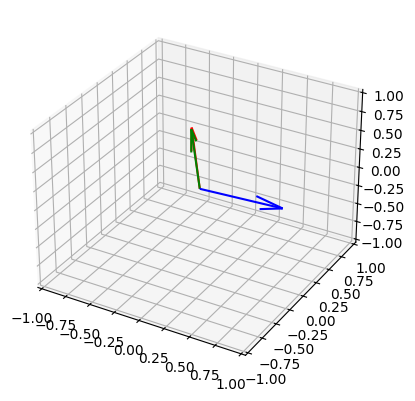

Image: frame_2962


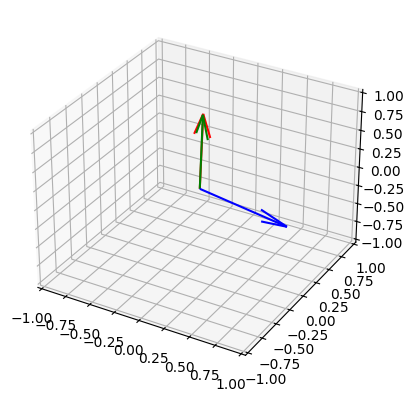

Image: frame_548


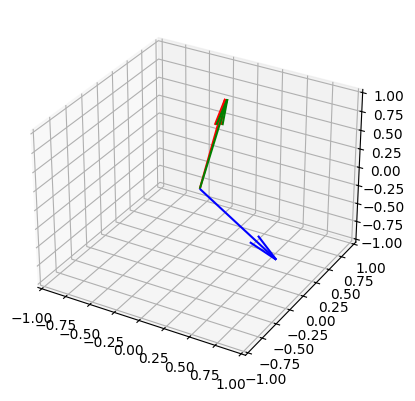

Image: frame_639


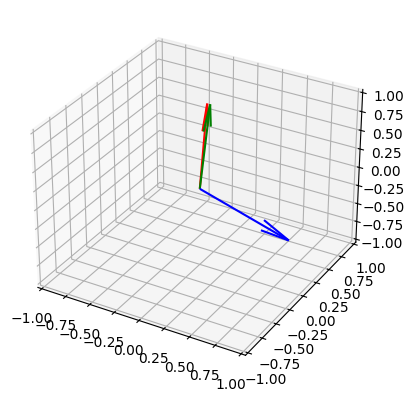

Image: frame_1139


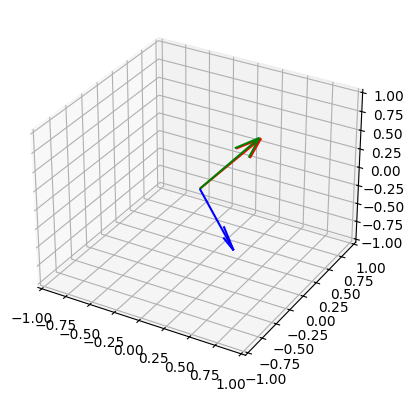

In [71]:
# Plotting the 3 normal vectors in 3D for first 5 images

for i in range(5):
    print(f"Image: {lidar_images[i].filename}")
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    image = lidar_images[i]
    ax.quiver(0, 0, 0, image.camera_normals[0], image.camera_normals[1], image.camera_normals[2], color='r')
    ax.quiver(0, 0, 0, lidar_normals[i][0], lidar_normals[i][1], lidar_normals[i][2], color='b')
    ax.quiver(0, 0, 0, projected_lidar_normals[i][0], projected_lidar_normals[i][1], projected_lidar_normals[i][2], color='g')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    plt.show()

Mean Cosine Similarity: 0.9993391939774698
Standard Deviation: 0.002750802985398831


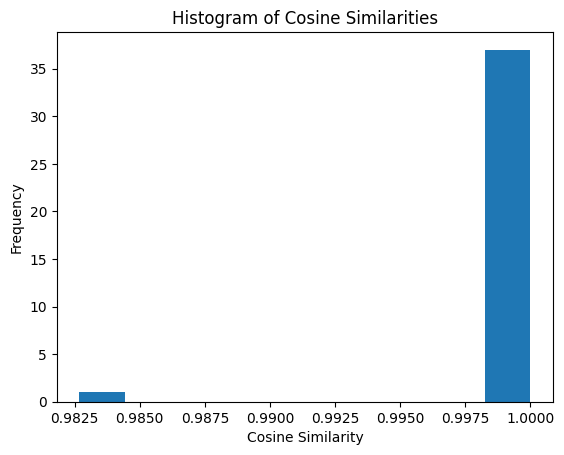

In [72]:
# Computing cosine distance between the camera and projected lidar normals for all images

cos_sim = []
for i in range(len(image_names)):
    lidar_image = LidarImage(image_names[i])
    points = np.asarray(lidar_image.lidar_scan.points)
    lidar_centroid = np.mean(points, axis=0)
    centered_points = points - lidar_centroid
    _, _, Vt = np.linalg.svd(centered_points)
    lidar_normal = Vt[-1]
    lidar_image.camera_normals = lidar_image.camera_normals / np.linalg.norm(lidar_image.camera_normals)
    lidar_normal = lidar_normal / np.linalg.norm(lidar_normal)
    lidar_offset = np.dot(lidar_normal, lidar_centroid)
    if lidar_offset < 0:
        lidar_normal = -lidar_normal
    camera_offset = np.dot(lidar_image.camera_normals, lidar_image.translation_vector.T)
    if camera_offset < 0:
        lidar_image.camera_normals = -lidar_image.camera_normals

    projected_lidar_normal = np.matmul(rot_mat, lidar_normal)
    cosine_similarity = np.dot(projected_lidar_normal, lidar_image.camera_normals.T) / (np.linalg.norm(projected_lidar_normal) * np.linalg.norm(lidar_image.camera_normals))
    cos_sim.append(cosine_similarity)

print(f"Mean Cosine Similarity: {np.mean(cos_sim)}")
print(f"Standard Deviation: {np.std(cos_sim)}")

# Plotting the histogram of cosine similarities
plt.hist(cos_sim, bins=10)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Similarities')
plt.show()